# MAESTRO dataset

#### Referencia

Curtis Hawthorne, Andriy Stasyuk, Adam Roberts, Ian Simon, Cheng-Zhi Anna Huang,  \
  Sander Dieleman, Erich Elsen, Jesse Engel, and Douglas Eck. "Enabling  \
  Factorized Piano Music Modeling and Generation with the MAESTRO Dataset."  \
  In International Conference on Learning Representations, 2019.  

# Background

El modelo de Transformer para NLP funciona en base a secuencias de tokens. En la mayoría de los casos, un token equivale a una palabra. Los tokens se mapean a un vector one-hot para luego ser procesados por una capa de embedding, y luego pasan a las capas principales del transformer.

Para poder ocupar un transformer, es necesario usar una notación especial, detallada en el paper This Time with Feeling: Learning Expressive Musical Performance (Oore et al. 2018). En este paper se presenta el trabajo sobre la red denominada PerformanceRNN.

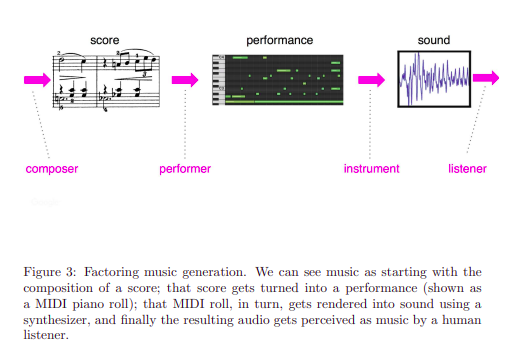

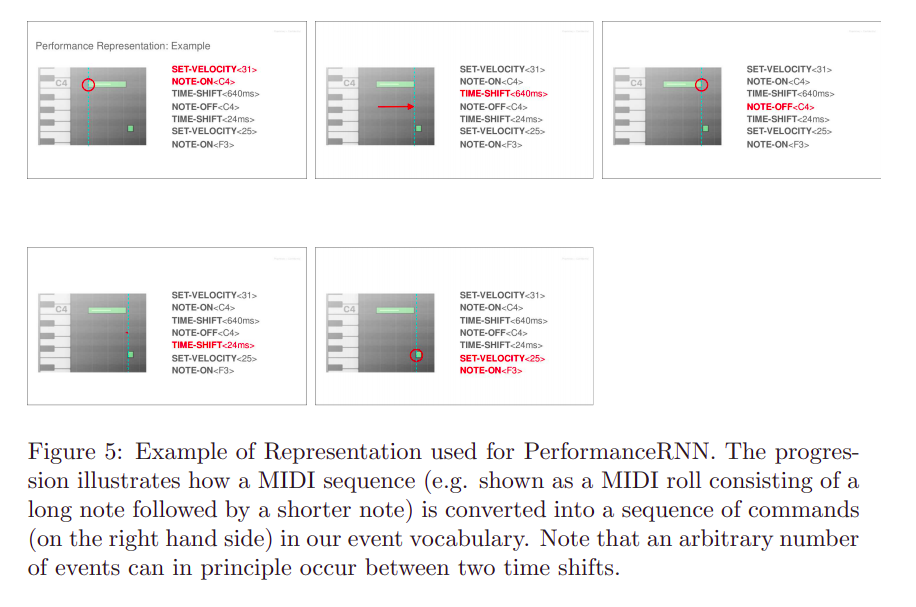

# Implementación

In [1]:
import pypianoroll
from matplotlib import pyplot as plt
import numpy as np

In [7]:
class Parser:
    
    @staticmethod
    def load_midi_as_track(midi_file_path):
        """
        Lee un midi single-track y debuelve el objeto Track de pypianoroll
        """
        multitrack = pypianoroll.parse(midi_file_path)
        track = multitrack.tracks[0]
        return track

    @staticmethod
    def encode(pianoroll):
        """
        Recibe la matriz del track (pianoroll) y devuelve
        una lista con los tokens.
        """
        sequence = []
        pianoroll = pianoroll.astype('int8')

        previous_row = np.zeros(pianoroll.shape[1])
        previous_velocity = 0
        timeshift = 0

        for t, row in enumerate(pianoroll):

            if all(row == previous_row):
                timeshift += 1
            else:
                sequence.append(f'TIMESHIFT<{timeshift}>')
                timeshift = 1

                difference = row - previous_row
                changed_notes = np.where(difference != 0)[0]

                for n in changed_notes:

                    # Si la nota cambió y antes era 0, solo pudo haberse encendido.
                    if previous_row[n] == 0:
                        sequence.append(f'NOTE-ON<{n}>')

                    # Si la nota cambió y ahora esta en 0, solo pudo haberse apagado.
                    elif row[n] == 0:
                        sequence.append(f'NOTE-OFF<{n}>')

                    velocity = int(np.take(row, changed_notes).mean())
                    if velocity != previous_velocity and velocity != 0:
                        sequence.append(f'SET-VELOCITY<{velocity}>')
                        previous_velocity = velocity

            previous_row = row

        return sequence

    @staticmethod
    def decode(encoded_sequence):
        """
        Retorna una matriz que representa al pianoroll, dada
        una lista de tokens.
        """
        def get_number(token):
            return int(token.split('<')[1].strip('>'))

        pitches = 128

        new_pianoroll = []
        on_notes = list(np.zeros(pitches))
        velocity = 0

        for token in encoded_sequence:

            if 'TIMESHIFT' in token:
                new_row = np.array(on_notes) * velocity
                timesteps = get_number(token)

                for t in range(timesteps):
                    new_pianoroll.append(list(new_row))

            elif 'NOTE-ON' in token:
                note = get_number(token)
                on_notes[note] = 1

            elif 'NOTE-OFF' in token:
                note = get_number(token)
                on_notes[note] = 0

            elif 'SET-VELOCITY' in token:
                velocity = get_number(token)

        return np.array(new_pianoroll)

# MAESTRO Dataset

In [3]:
# // Esta linea se uso para cambiar las extensiones de .midi a .mid
# !while read f; do mv -- "$f" "${f%.midi}.mid"; done < maestro_paths.txt

In [8]:
!find "../maestro-v2.0.0" -name "*.mid" > maestro_paths.txt

In [9]:
with open('maestro_paths.txt') as f:
    paths = list(map(lambda x: x.strip(), f.readlines()))

In [10]:
paths

['../maestro-v2.0.0/2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--1.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--1.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_11_R1_2014_wav--1.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--6.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--8.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_21-22_R1_2014_MID--AUDIO_21_R1_2014_wav--6.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_12_R1_2014_wav--1.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--2.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--3.mid',
 '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1.mid',

In [11]:
!vlc  '../maestro-v2.0.0/2014/MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4.mid'

VLC media player 3.0.10 Vetinari (revision 3.0.10-0-g7f145afa84)
[000056095f3cfb10] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
Qt: Session management error: None of the authentication protocols specified are supported
[00007f079c001190] smf demux: Track name: 06/30  4~5
fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.
[00007f079c001190] smf demux: Track name: 06/30  4~5
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 1 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 2 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 3 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 4 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 5 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 6 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 7 [bank=0 prog=0]
fluidsynth: warn

In [13]:
pianoroll = Parser.load_midi_as_track(paths[0]).pianoroll

In [14]:
encoded = Parser.encode(pianoroll)

In [15]:
len(encoded)

26309

In [16]:
# Vocabulario
len(np.unique(encoded))

252

In [17]:
encoded

['TIMESHIFT<47>',
 'NOTE-ON<45>',
 'SET-VELOCITY<55>',
 'TIMESHIFT<1>',
 'NOTE-ON<57>',
 'SET-VELOCITY<52>',
 'TIMESHIFT<1>',
 'NOTE-OFF<45>',
 'NOTE-OFF<57>',
 'TIMESHIFT<8>',
 'NOTE-ON<50>',
 'SET-VELOCITY<62>',
 'NOTE-ON<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'TIMESHIFT<6>',
 'NOTE-ON<57>',
 'SET-VELOCITY<69>',
 'TIMESHIFT<1>',
 'NOTE-ON<45>',
 'SET-VELOCITY<63>',
 'TIMESHIFT<1>',
 'NOTE-OFF<57>',
 'TIMESHIFT<1>',
 'NOTE-OFF<45>',
 'TIMESHIFT<6>',
 'NOTE-ON<62>',
 'SET-VELOCITY<75>',
 'TIMESHIFT<1>',
 'NOTE-ON<50>',
 'SET-VELOCITY<64>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'NOTE-OFF<62>',
 'TIMESHIFT<7>',
 'NOTE-ON<54>',
 'SET-VELOCITY<76>',
 'NOTE-ON<66>',
 'TIMESHIFT<1>',
 'NOTE-OFF<54>',
 'TIMESHIFT<1>',
 'NOTE-OFF<66>',
 'TIMESHIFT<7>',
 'NOTE-ON<50>',
 'SET-VELOCITY<72>',
 'NOTE-ON<62>',
 'TIMESHIFT<1>',
 'NOTE-OFF<50>',
 'NOTE-OFF<62>',
 'TIMESHIFT<8>',
 'NOTE-ON<66>',
 'SET-VELOCITY<85>',
 'TIMESHIFT<1>',
 'NOTE-ON<54>',
 'SET-VELOCITY<64>',


In [19]:
decoded = Parser.decode(encoded)

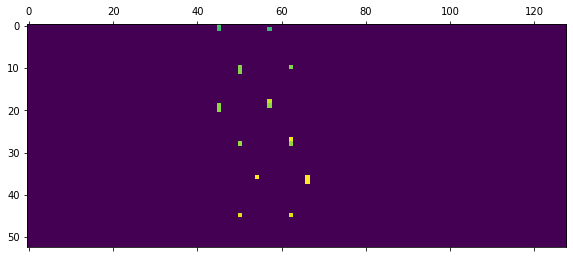

In [20]:
# Graficamos de vuelta el pianoroll
plt.matshow(decoded[47:100])

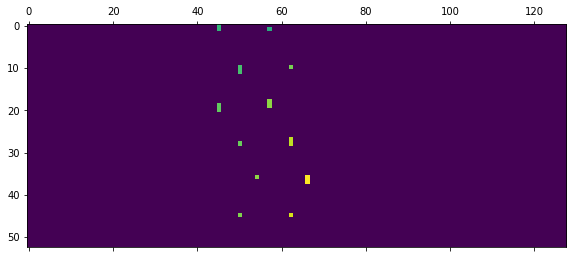

In [21]:
# Comparamos con el original
plt.matshow(pianoroll[47:100])

La única diferencia es que el nuevo pianoroll solo puede tocar a una 'velocity' a la vez.

# Comparación del sonido entre original y codificado

In [22]:
new_track = pypianoroll.Track(decoded)

In [23]:
initial_multitrack = pypianoroll.parse(paths[0])
new_multitrack = pypianoroll.Multitrack(tracks=[new_track])

In [24]:
initial_multitrack.write('initial.mid')
new_multitrack.write('after.mid')

In [1]:
!vlc initial.mid

VLC media player 3.0.10 Vetinari (revision 3.0.10-0-g7f145afa84)
[0000563eaebdcb10] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
Qt: Session management error: None of the authentication protocols specified are supported
[00007f9120004040] smf demux: Track name: 06/30  4~5
fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.
[00007f9120004040] smf demux: Track name: 06/30  4~5
fluidsynth: warning: No preset found on channel 0 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 1 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 2 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 3 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 4 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 5 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 6 [bank=0 prog=0]
fluidsynth: warning: No preset found on channel 7 [bank=0 prog=0]
fluidsynth: warn

In [ ]:
!vlc after.mid

VLC media player 3.0.10 Vetinari (revision 3.0.10-0-g7f145afa84)
[000055711e7f1b10] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
Qt: Session management error: None of the authentication protocols specified are supported
[00007f4b24c0b060] smf demux: Track name: unknown
fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.
[00007f4b24c0b060] smf demux: Track name: unknown


# Parsing all dataset

A continuación se codifica el datate completo y se guardan las secuencias en archivos .txt.

In [51]:
from os.path import join

In [55]:
!mkdir maestro_encoded

mkdir: cannot create directory ‘maestro_encoded’: File exists


In [53]:
len(paths)

1282

In [62]:
vocabulary = set()

for i, midi_path in enumerate(paths):
    track = Parser.load_midi_as_track(midi_path)
    encoded = Parser.encode(track.pianoroll)
    vocabulary.update(encoded)

    maestro_string_index = midi_path.index('maestro') # esto es porque los paths son '../maestro-v2.0.0 ...'
    file_name = midi_path[maestro_string_index:].replace('/', '---').rstrip('.mid') + '.txt'
    
    with open(join('maestro_encoded', file_name), 'w') as f:
        string_sequence = ','.join(encoded)
        f.write(string_sequence)
    
    print(f'{i}/{len(paths)}...', end='\r')

In [63]:
print(len(vocabulary))

912


In [64]:
with open('vocabulary.txt', 'w') as f:
    f.write(','.join(list(vocabulary)))